# **Agentic RAG with Cohere and Pinecone**

## TODO:
1. Provision Cohere API keys for AWS attendees

In [ ]:
# Install required libraries
!pip install pinecone cohere duckduckgo-search

In [1]:
from datetime import datetime, timedelta, date
import json
from pinecone import Pinecone
import getpass
import cohere

# AWS Library imports
import boto3
import botocore
from botocore.config import Config

from duckduckgo_search import DDGS

In [10]:
COHERE_API_KEY = getpass.getpass("Enter Cohere API Key")
co = cohere.ClientV2(COHERE_API_KEY)

Enter Cohere API Key ········


In [ ]:
PINECONE_API_KEY = getpass.getpass("Enter Pinecone API Key")
pc = Pinecone(api_key="PINECONE_API_KEY")

In [ ]:
pinecone_index_name = 'pinecone-cohere-workshop' #Provide Pinecone Index name that we created in the 'Create Pinecone Index' section
pinecone_namespace = 'agentic-rag' #Provide Pinecone namespace where we have uploaded the data in the data loading notebook

In [ ]:

index = pc.Index(pinecone_index_name)
print(index.describe_index_stats())

## **1. Key Concepts**

### 1.1 Tools

RAG gives LLMs the capability to ground their responses in external text data retrived from a Vector Database

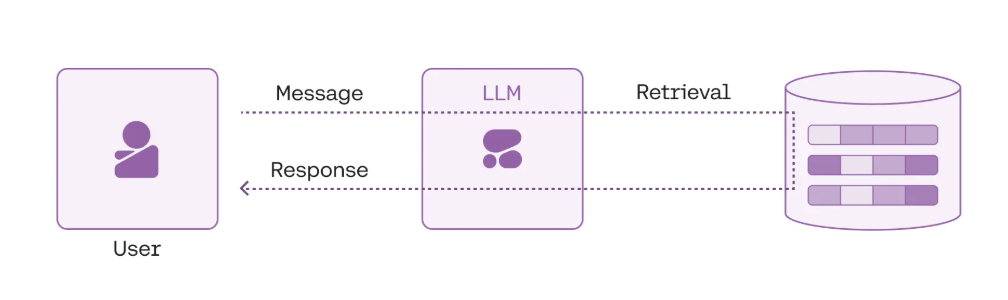


Tool use extends/generalizes this concept. A tool can be considered any service that an LLM can communicate with (eg: a search engine, a SQL database, a service like Notion, a python interpreter etc.). An LLM can be connected to one or more tools

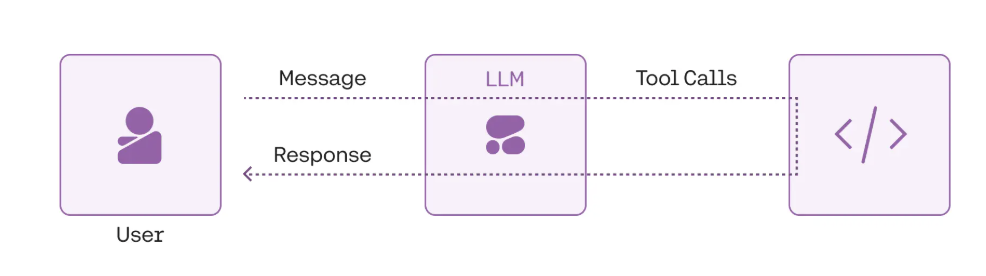

### 1.2 Decision Making

With Tool-Use the LLM acts as decision-making engine. It has to decide:


1.   Whether a user query can be answered directly or requires some external context from a tool
2.   If tools are required, which tools would those be, and how to call them

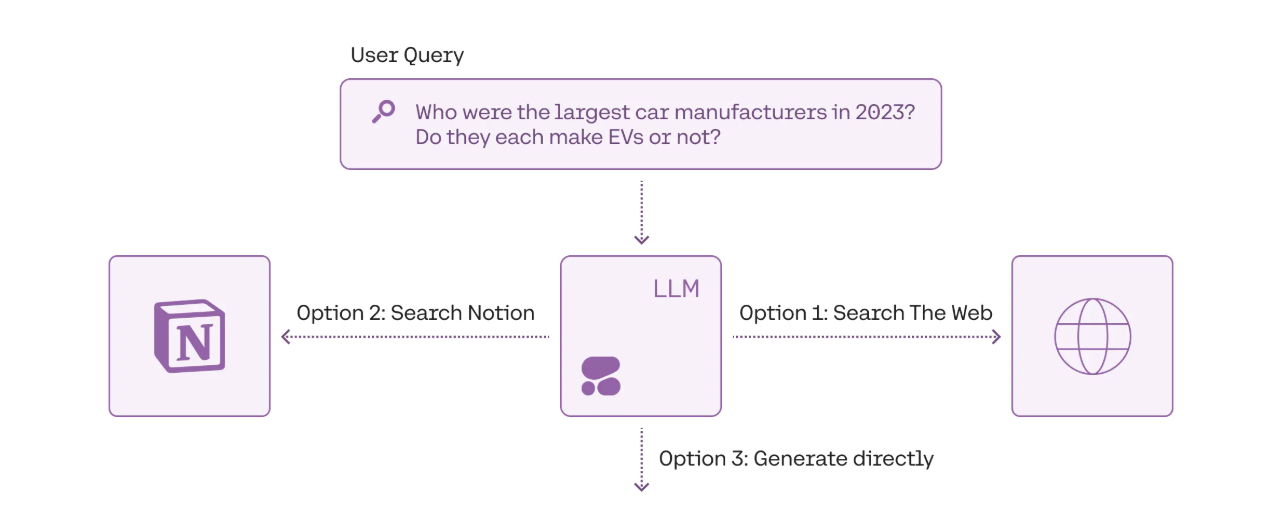



### 1.3 Action

While RAG is a read-only setup, Tool use enables developers to build applications that can take actions (i.e read and write to external systems via APIs)

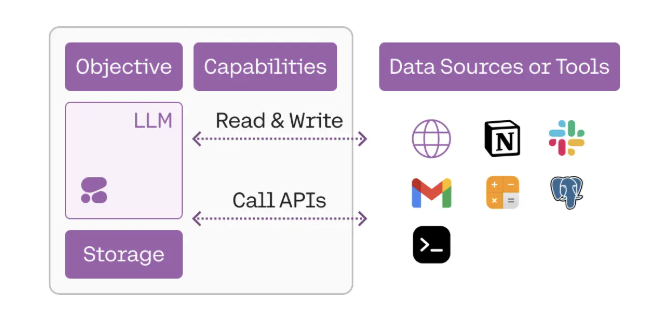


### 1.4 Function Calling

If tool use is the "what" of LLM capability extension, function calling is the "how". Function calling is a specific implementation of tool use, focusing on the technical details of picking the tools to call and generating the payload to call the tool.

## **2. Basic Implementation**

### **2.1 Setup the Tool**
### 2.1.1 Create the tools
This is a mocked search engine for demo purposes. The tool can be any function or service that can receive and send data - an email service, an SQL database, a vector database, a weather data service,or even another LLM



In [3]:
# Tool 1: Web search engine
def web_search_engine(query: str) -> dict:
    
    search_results = DDGS().text("Company where Andy Jassy is CEO", max_results=5)
    
    return search_results

In [4]:
# map tools
functions_map = {
    "web_search_engine": web_search_engine,
}

### 2.1.2 Define the Tool Schema

The schema is what will be passed to the Cohere API when running a tool use workflow. The schema informs the LLM about what the tool does, and the LLM decides whether to use a particular tool based on it. Therefore, the more descriptive and specific the schema, the more likely the LLM will make the right tool call decisions.

In [5]:
web_search_engine_tool =  {
    "type": "function",
    "function": {
        "name": "web_search_engine",
        "description": "Searches the internet and retrieves content relevant to the input query",
        "parameters": {
            "type": "object",
            "properties": {
                "query": {
                    "type": "string",
                    "description": "The search query.",
                }
            },
            "required": ["query"],
        },
    },
}


tools = [
  web_search_engine_tool
]

### 2.1.3 Define the LLM System Message

Here you can provide context to the LLM on the task, provide guide on style of response etc.


In [6]:
formated_date = date.today().strftime("%A, %B %d, %Y")

SYSTEM_MESSAGE = """## Task and Context
You are an assistant who helps developers use Cohere. 
You are equipped with a number of tools that can provide different types of information. 
If you can't find the information you need from one tool, you should try other tools if there is a possibility that they could provide the information you need.

## Date
Today date is {}

## Style Guide
Unless the user asks for a different style of answer, you should answer in full sentences, using proper grammar and spelling""".format(formated_date)

messages = []
if "system" not in {m.get("role") for m in messages}:
    messages.append({"role": "system", "content": SYSTEM_MESSAGE})

## **2.2 Define the Workflow**

We can think of a tool use system as consisting of four components:

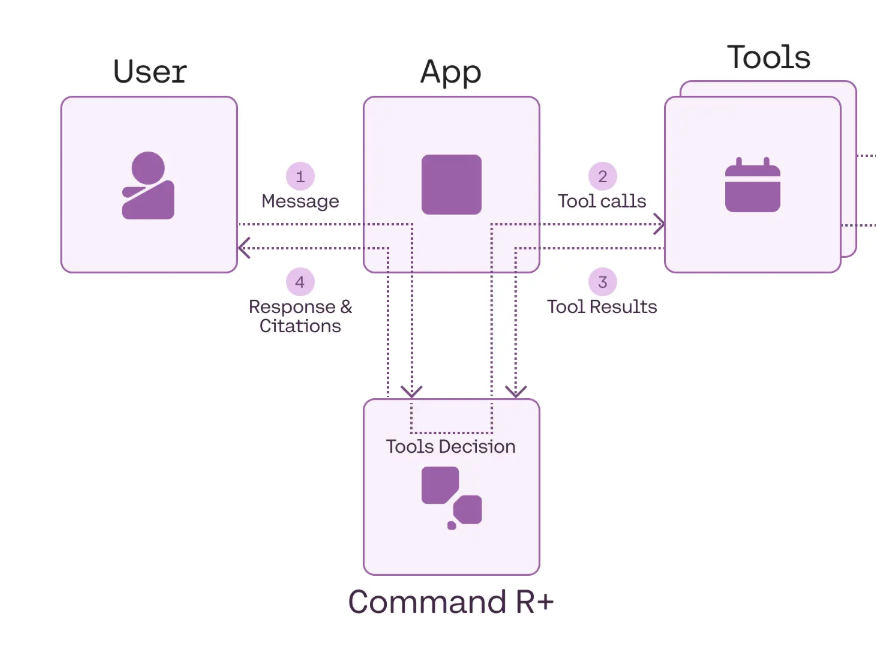

### 2.2.1  Get user message
The LLM gets the user query (via the application).

In [7]:
query = "Which company is Andy Jassy CEO of?"
messages.append({"role": "user", "content": query})

In [8]:
messages

[{'role': 'system',
  'content': "## Task and Context\nYou are an assistant who helps developers use Cohere. \nYou are equipped with a number of tools that can provide different types of information. \nIf you can't find the information you need from one tool, you should try other tools if there is a possibility that they could provide the information you need.\n\n## Date\nToday date is Monday, May 19, 2025\n\n## Style Guide\nUnless the user asks for a different style of answer, you should answer in full sentences, using proper grammar and spelling"},
 {'role': 'user', 'content': 'Which company is Andy Jassy CEO of?'}]

### 2.2.2 LLM generates tool plan and calls.
The LLM decides which tools to call (if any) and generates the tool calls.

In [11]:
MODEL = "command-a-03-2025"

response = co.chat(
    model=MODEL, 
    messages=messages, 
    tools=tools, 
    temperature=0.3
)

messages.append(
    {
        "role": "assistant",
        "tool_calls": response.message.tool_calls,
        "tool_plan": response.message.tool_plan,
    }
)

The LLM generates a tool plan

In [12]:
print("TOOL PLAN:")
print(response.message.tool_plan, "\n")

TOOL PLAN:
I will search for 'Andy Jassy CEO of which company'. 



The LLM recommends the tools and associated parameters for the tool

In [13]:
print("TOOL CALLS:")
for tc in response.message.tool_calls:
    print(
        f"Tool name: {tc.function.name} | Parameters: {tc.function.arguments}"
    )
print("=" * 50)

TOOL CALLS:
Tool name: web_search_engine | Parameters: {"query":"Andy Jassy CEO of which company"}


### 2.2.3 Application executes the tool and collects results
The application executes the tools based the recommended parameter. The application may run its own logic (eg: validate parameter recommendations) before execution

In [14]:
for tc in response.message.tool_calls:
    tool_result = functions_map[tc.function.name](
        **json.loads(tc.function.arguments)
    )
    
    tool_content = []
    for data in tool_result:
        tool_content.append(
            {
                "type": "document",
                "document": {"data": json.dumps(data)},
            }
        )
        # Optional: add an "id" field in the "document" object, otherwise IDs are auto-generated
    messages.append(
        {
            "role": "tool",
            "tool_call_id": tc.id,
            "content": tool_content,
        }
    )


In [15]:
print(tool_result)

[{'title': 'Andy Jassy - Wikipedia', 'href': 'https://en.wikipedia.org/wiki/Andy_Jassy', 'body': 'Andrew R. Jassy (born January 13, 1968) [5] is an American business executive who is the president and chief executive officer of Amazon.Before being appointed by Jeff Bezos and the Amazon board during the fourth quarter of 2020, [6] [7] Jassy had been the SVP and CEO of Amazon Web Services from 2003 to 2021. [8]'}, {'title': 'Amazon.com, Inc. - Officers and directors - Person Details', 'href': 'https://ir.aboutamazon.com/officers-and-directors/person-details/default.aspx?ItemId=7601ef7b-4732-44e2-84ef-2cccb54ac11a', 'body': 'Andy Jassy is President and CEO of Amazon.com and also serves on the Board of Directors. He founded and led Amazon Web Services (AWS) from its inception and served as its CEO from April 2016 until July 2021. ... 2016 until July 2021. He joined Amazon in 1997 and, prior to founding AWS, held various leadership roles across the company, including ...'}, {'title': "Andy 

### 2.2.4 LLM reasons over tool results to generate response with citations.
The LLM generates the response and citations back to the user.

In [16]:
response = co.chat(
            model=MODEL,
            messages=messages,
            tools=tools,
            temperature=0.3,
        )

In [17]:
# Print final response
print("RESPONSE:")
print(response.message.content[0].text)
print("=" * 50)

if response.message.citations:
    print("CITATIONS:\n")
    for citation in response.message.citations:
        print(
            f"Start: {citation.start}| End:{citation.end}| Text:'{citation.text}' "
        )
        print("Sources:")
        for idx, source in enumerate(citation.sources):
            print(f"{idx+1}. {source.id}")
            print(f"{source.tool_output}")
        print("\n")

RESPONSE:
Andy Jassy is the President and CEO of Amazon. He joined the company in 1997 and founded and led Amazon Web Services (AWS) from 2003 to 2021. He became CEO in 2021 when Jeff Bezos stepped down.
CITATIONS:

Start: 18| End:27| Text:'President' 
Sources:
1. web_search_engine_ys96zv2vtb93:0
{'body': 'Andrew R. Jassy (born January 13, 1968) [5] is an American business executive who is the president and chief executive officer of Amazon.Before being appointed by Jeff Bezos and the Amazon board during the fourth quarter of 2020, [6] [7] Jassy had been the SVP and CEO of Amazon Web Services from 2003 to 2021. [8]', 'href': 'https://en.wikipedia.org/wiki/Andy_Jassy', 'title': 'Andy Jassy - Wikipedia'}
2. web_search_engine_ys96zv2vtb93:1
{'body': 'Andy Jassy is President and CEO of Amazon.com and also serves on the Board of Directors. He founded and led Amazon Web Services (AWS) from its inception and served as its CEO from April 2016 until July 2021. ... 2016 until July 2021. He joine

## **3. Multiple tools in Multi-turn Chat**

### **3.1 Single Step Tool Use**


The LLM can manage multiple tools in multi-turn chat scenario. In a single-step scenario the LLM decided to call one or more tool independently

Let's add an additional tool

In [ ]:
# Initialize Bedrock

config = Config(connect_timeout=5, read_timeout=60, retries={"total_max_attempts": 20, "mode": "adaptive"})
region = 'us-west-2'

bedrock = boto3.client(
                service_name='bedrock-runtime',
                region_name=region,
                endpoint_url=f'https://bedrock-runtime.{region}.amazonaws.com',
                                    config=config)

In [ ]:
# Cohere Embedding model in Bedrock

def cohere_embed_query(docs: str, input_type: str) -> list[float]:
    """
    Generate text embedding by using the Cohere Embed model.
    Args:
        docs: string of text to embed.
        input_type: select between [search_document, search_query, classification, clustering, image]
    Returns:
        dict: embeddings in float type.
    """

    body = json.dumps({
        "texts": [docs],
        "input_type": input_type,
        "embedding_types": ["float"]

    })
    
    model_id = 'cohere.embed-english-v3'
    accept = 'application/json' 
    content_type = 'application/json'
    
    # Invoke model 
    response = bedrock.invoke_model(
        body=body, 
        modelId=model_id, 
        accept=accept, 
        contentType=content_type
    )
    
    # Parse response
    response_body = json.loads(response['body'].read())
    embedding = response_body.get('embeddings')['float'][0]
    
    return embedding

In [18]:
# Tool 2: Query Pinecone DB

def query_pinecone_db(query: str) -> list[dict]:
    query_embedding = cohere_embed_query(query, input_type="search_query")

    results = index.query(
        namespace=pinecone_namespace,
        vector=query_embedding,
        top_k=20,
        include_metadata=True,
    )
    query_results = [{"chunk_text": rec['metadata']['chunk_text']} for rec in results['matches']]
    # Sample results would look like below
    #search_results = [
    #    {"chunk_text": "Amazon revenue for 2025 is $3 Billion"},
    #    {"chunk_text": "Amazon revenue for 2024 is $2 Billion"},
    #    {"chunk_text": "Amazon revenue for 2024 is $1 Billion"},
    #]
    return query_results

functions_map = {
    "web_search_engine": web_search_engine,
    "query_pinecone_db": query_pinecone_db,
}

In [19]:
query_pinecone_db_tool =  {
    "type": "function",
    "function": {
        "name": "query_pinecone_db",
        "description": "Searches Pinecone vector database index to retrieve documents relevant to the input query. The index contain financial statement data related to Amazon",
        "parameters": {
            "type": "object",
            "properties": {
                "query": {
                    "type": "string",
                    "description": "The search query.",
                }
            },
            "required": ["query"],
        },
    },
}

In [20]:
tools = [
    web_search_engine_tool, 
    query_pinecone_db_tool,
]

Let update the system message to provide guidance to the model on tool use

In [21]:
SYSTEM_MESSAGE = """## Task and Context
You are an assistant who helps developers use Cohere. 
You are equipped with a number of tools that can provide different types of information. 
If you can't find the information you need from one tool, you should try other tools if there is a possibility that they could provide the information you need.

## Date
Today date is {}

## Style Guide
Unless the user asks for a different style of answer, you should answer in full sentences, using proper grammar and spelling

## Tool Guide
For queries related to financial information use pinecone vector database. 
For other queries use websearch

""".format(formated_date)

The workflow we defined is looped over to handle multiple tools

In [22]:
def run_agent(query, messages=None, verbose_source=False):
    
    if messages is None:
        messages = []
    if "system" not in {m.get("role") for m in messages}:
        messages.append({"role": "system", "content": SYSTEM_MESSAGE})
        
    # Step 1: get user message
    print(f"QUESTION:\n{query}")
    print("=" * 50)
    messages.append({"role": "user", "content": query})
    
    # Step 2: Generate tool calls (if any)
    response = co.chat(
        model=MODEL, messages=messages, tools=tools, temperature=0.3
    )
    
    while response.message.tool_calls:
        print("TOOL PLAN:")
        print(response.message.tool_plan, "\n")
        print("TOOL CALLS:")
        for tc in response.message.tool_calls:
            print(
                f"Tool name: {tc.function.name} | Parameters: {tc.function.arguments}"
            )
        print("=" * 50)
        messages.append(
            {
                "role": "assistant",
                "tool_calls": response.message.tool_calls,
                "tool_plan": response.message.tool_plan,
            }
        )
        
        # Step 3: Get tool results
        for tc in response.message.tool_calls:
            print(functions_map[tc.function.name])
            print(tc.function.arguments)
            tool_result = functions_map[tc.function.name](
                **json.loads(tc.function.arguments)
            )
            tool_content = []
            
            for data in tool_result:
                tool_content.append(
                    {
                        "type": "document",
                        "document": {"data": json.dumps(data)},
                    }
                )
            # Optional: add an "id" field in the "document" object, otherwise IDs are auto-generated
            messages.append(
                {
                    "role": "tool",
                    "tool_call_id": tc.id,
                    "content": tool_content,
                }
            )
            
        # Step 4: Generate response and citations
        response = co.chat(
            model=MODEL,
            messages=messages,
            tools=tools,
            temperature=0.3,
        )
        
    messages.append(
        {
            "role": "assistant",
            "content": response.message.content[0].text,
        }
    )
    
    # Print final response
    print("RESPONSE:")
    print(response.message.content[0].text)
    print("=" * 50)
    # Print citations (if any)

    if response.message.citations:
        print("CITATIONS:\n")
        for citation in response.message.citations:
            print(
                f"Start: {citation.start}| End:{citation.end}| Text:'{citation.text}' "
            )
            print("Sources:")
            for idx, source in enumerate(citation.sources):
                print(f"{idx+1}. {source.id}")
                if verbose_source:
                    print(f"{source.tool_output}")
            print("\n")
            
    return messages

In [23]:
messages = run_agent("Which company is Andy Jassy CEO of?", messages=[])

QUESTION:
Which company is Andy Jassy CEO of?
TOOL PLAN:
I will search for 'Andy Jassy CEO' to find out which company he is CEO of. 

TOOL CALLS:
Tool name: web_search_engine | Parameters: {"query":"Andy Jassy CEO"}
<function web_search_engine at 0x1078c2c00>
{"query":"Andy Jassy CEO"}
RESPONSE:
Andy Jassy is the President and CEO of Amazon. He joined the company in 1997 and founded Amazon Web Services (AWS), of which he was CEO from April 2016 until July 2021.
CITATIONS:

Start: 18| End:27| Text:'President' 
Sources:
1. web_search_engine_f7bt0jrr5knb:0
2. web_search_engine_f7bt0jrr5knb:1
3. web_search_engine_f7bt0jrr5knb:2


Start: 32| End:35| Text:'CEO' 
Sources:
1. web_search_engine_f7bt0jrr5knb:0
2. web_search_engine_f7bt0jrr5knb:1
3. web_search_engine_f7bt0jrr5knb:2
4. web_search_engine_f7bt0jrr5knb:3
5. web_search_engine_f7bt0jrr5knb:4


Start: 39| End:46| Text:'Amazon.' 
Sources:
1. web_search_engine_f7bt0jrr5knb:0
2. web_search_engine_f7bt0jrr5knb:1
3. web_search_engine_f7bt0jr

In [24]:
messages = run_agent("What is the revenue of that company in 2025?", messages=messages)

QUESTION:
What is the revenue of that company in 2025?
TOOL PLAN:
I will search for Amazon's revenue in 2025. 

TOOL CALLS:
Tool name: query_pinecone_db | Parameters: {"query":"Amazon revenue 2025"}
<function query_pinecone_db at 0x1095879c0>
{"query":"Amazon revenue 2025"}
RESPONSE:
Amazon's revenue for 2025 is $3 billion.
CITATIONS:

Start: 29| End:40| Text:'$3 billion.' 
Sources:
1. query_pinecone_db_wthtcsfqpj1t:0




### **3.2 Multi Step Tool Use**

In Multi-step tool use, the LLM engages in "planning" to determine what tools need to be called and the "sequence" in which they will be called, to answer the user query. This enables the capability for the LLM to autonomously perform complex tasks using a Thought-Action-Observation reasoning series

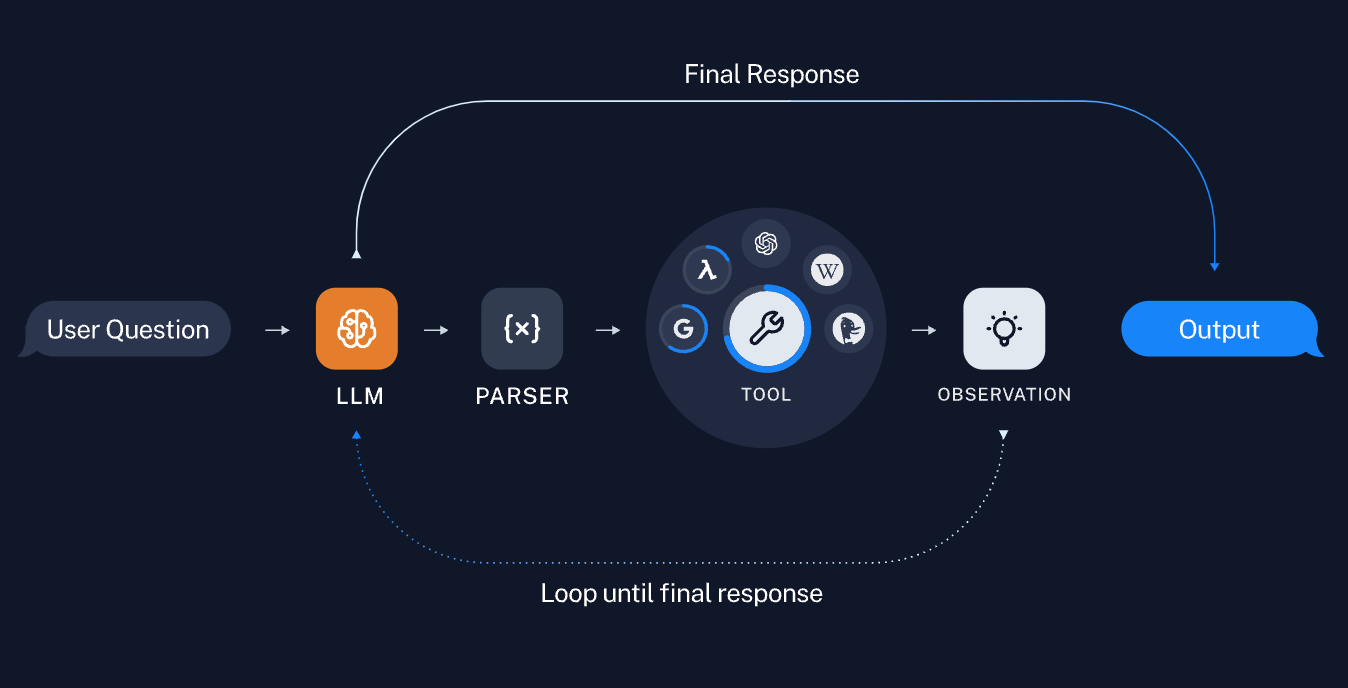


Compared to the single-step tool-use, in multi-step tool use the output of the initial tool is an input to the subsequent tools

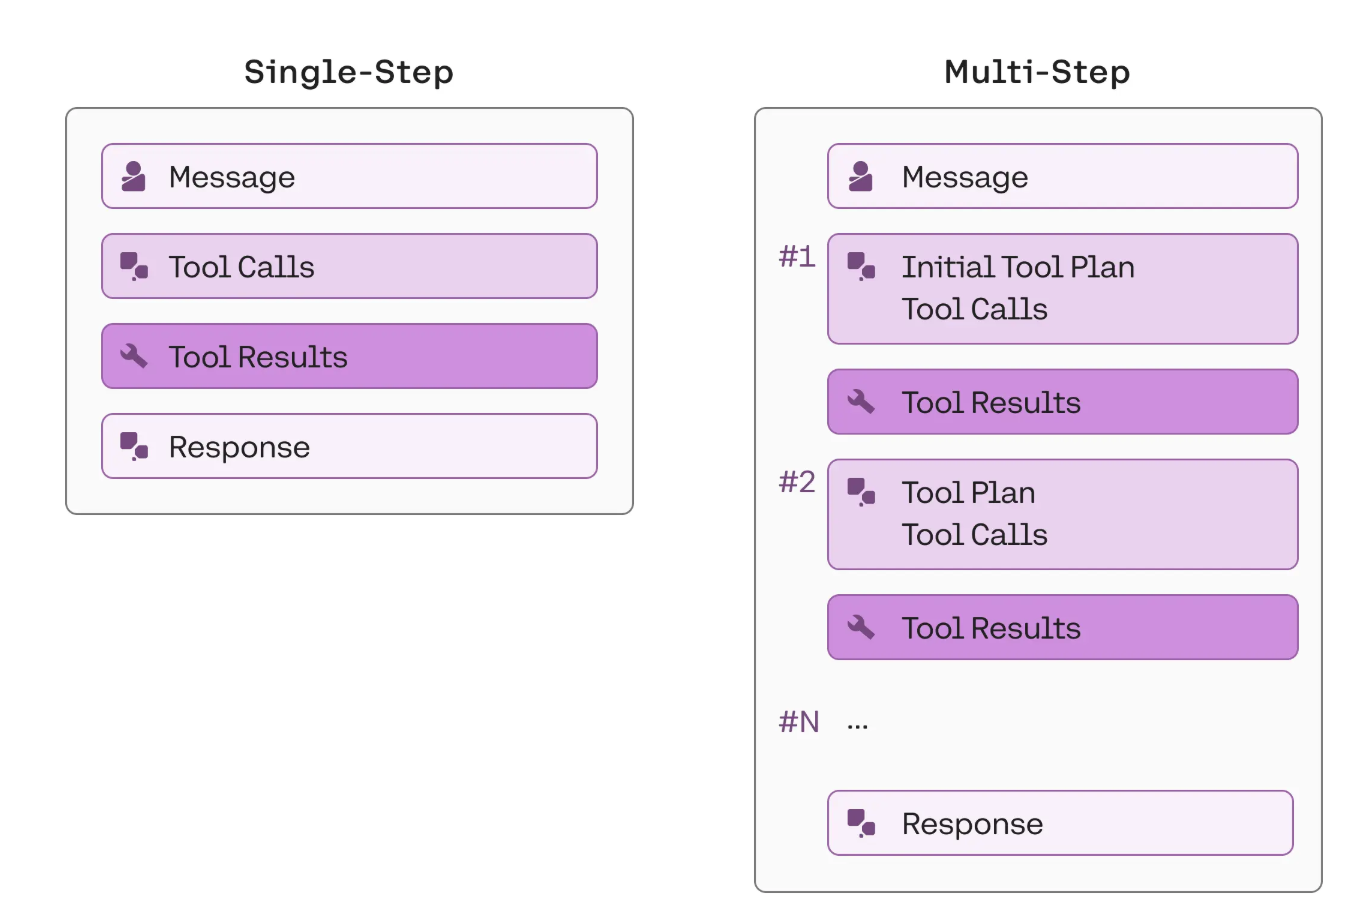


In [25]:
messages = run_agent("What is 2025 revenue of the company where Andy Jassy is currently CEO?", messages=[])

QUESTION:
What is 2025 revenue of the company where Andy Jassy is currently CEO?
TOOL PLAN:
I will first search for the company where Andy Jassy is currently CEO. Then, I will search for the 2025 revenue of that company. 

TOOL CALLS:
Tool name: web_search_engine | Parameters: {"query":"company where Andy Jassy is currently CEO"}
<function web_search_engine at 0x1078c2c00>
{"query":"company where Andy Jassy is currently CEO"}
TOOL PLAN:
I have found that Andy Jassy is the President and CEO of Amazon.com. I will now search for the 2025 revenue of Amazon.com. 

TOOL CALLS:
Tool name: query_pinecone_db | Parameters: {"query":"Amazon.com revenue 2025"}
<function query_pinecone_db at 0x1095879c0>
{"query":"Amazon.com revenue 2025"}
RESPONSE:
Andy Jassy is the President and CEO of Amazon.com. The revenue of Amazon.com in 2025 is $3 billion.
CITATIONS:

Start: 18| End:35| Text:'President and CEO' 
Sources:
1. web_search_engine_etx5gh1f55v8:0
2. web_search_engine_etx5gh1f55v8:1


Start: 39| En